In [3]:
import utils
import r_pca
import wtt
import wrappers
import numpy as np
from pylab import plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
d = 10
n = 2 ** d
left = 0
right = 1
signal = utils.values(np.sqrt, left, right, n)
modes = [2] * d

In [7]:
preproc_1 = wrappers.RPCA_preprocessing_wrapper(1)

low_rank, sparse_parts, _ = preproc_1.adjust(signal, d, modes, lambda_scale=2.5)

In [54]:
#то, что было раньше
[u.data.size for u in sparse_parts]

[22, 43, 42, 17, 1, 8, 12, 21, 0, 0]

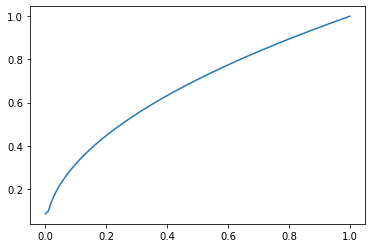

In [10]:
plt.plot(np.linspace(left, right, n), low_rank)
plt.show()

In [13]:
np.linalg.norm(preproc_1.add_sparse_parts(low_rank) - signal) / np.linalg.norm(signal)

3.426079035737869e-05

In [19]:
wtt_1 = wrappers.WTTwrapper(1)
wtt_1.adjust(low_rank, d, modes, eps=1e-6)
wtt_1.ranks #сравнительно малоранговое

[2, 4, 7, 7, 7, 6, 5, 3, 2]

In [23]:
wtt_result = wtt_1.apply(low_rank)
np.max(wtt_result[1:])

1.449336132766061e-05

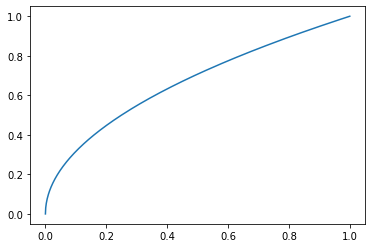

In [26]:
wtt_result[1:] = 0
iwtt_result = wtt_1.apply_inverse(wtt_result)
iwtt_result = preproc_1.add_sparse_parts(iwtt_result)

plt.plot(np.linspace(left, right, n), iwtt_result)

In [27]:
np.linalg.norm(iwtt_result - signal) / np.linalg.norm(signal)

3.427438076682936e-05

Тестируем тензоризованный препроцессинг.

In [29]:
preproc_2 = wrappers.RPCA_preprocessing_wrapper(2)

low_rank_part, sparse_parts, ranks = preproc_2.adjust(signal, d, modes, lambda_scale=2.5)

In [30]:
low_rank_part

array([0.08130122, 0.08255045, 0.08375563, ..., 0.99898575, 0.99945595,
       0.99991889])

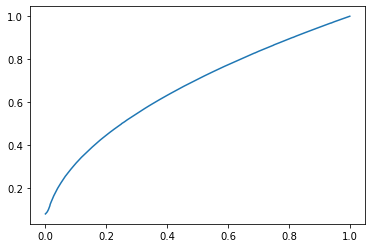

In [31]:
plt.plot(np.linspace(left, right, n), low_rank_part)
plt.show()

Что-то очень похожее на оригинальный корень, между прочим!

In [32]:
np.linalg.norm(low_rank_part - signal) / np.linalg.norm(signal)

0.005076014786933616

Посмотрим на характеристики разложения:

In [33]:
[s.data.size for s in sparse_parts]

[22, 38, 29, 11, 0, 6, 11, 26, 0, 0]

In [34]:
ranks

[2, 3, 4, 5, 4, 4, 4, 3, 2]

Попробуем теперь разложить малоранговую часть, что ли...

In [36]:
filters, true_ranks = wtt.wtt_filter(
    low_rank_part,
    d,
    modes,
    ranks=ranks
)

In [37]:
true_ranks

[2, 3, 4, 5, 4, 4, 4, 3, 2]

In [38]:
wtt_res = wtt.wtt_apply(
    low_rank_part,
    d,
    filters,
    modes,
    true_ranks
)

Что получилось:

In [39]:
np.max(wtt_res[1:])

2.4909398560856058e-15

Все коэффициенты, кроме первого --- нули! А ранги при этом крошечные.

In [41]:
zeroed_coeffs = np.zeros_like(wtt_res)
zeroed_coeffs[0] = wtt_res[0]

iwtt_res = wtt.iwtt_apply(
    zeroed_coeffs,
    d,
    filters,
    modes,
    true_ranks
)

print(np.linalg.norm(iwtt_res - low_rank_part))

2.3192420139693152e-14


Восстановим корень:

In [43]:
signal_restored = preproc_2.add_sparse_parts(iwtt_res)

Всё же у нас приближённое разложение $A = L + S_1 + \ldots + S_d$ (параметр ```tol``` в алгоритме).

In [44]:
np.linalg.norm(signal - signal_restored) / np.linalg.norm(signal)

0.00020064385128858088

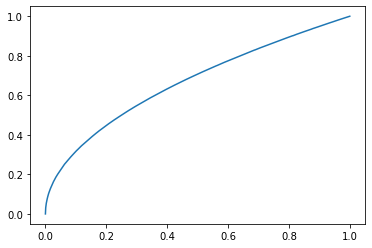

In [45]:
plt.plot(np.linspace(left, right, n), signal_restored)
plt.show()

Теперь посмотрим на простое 2D:

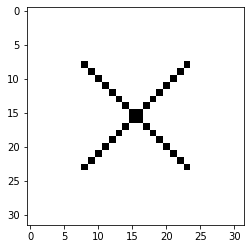

In [46]:
cross = np.full((32, 32), 255)
for i in range(8, 24):
    cross[i, i] = 0.
    cross[i, 31 - i] = 0.
plt.imshow(cross, cmap='gray')

In [47]:
d = 5
modes = [2] * d

vector, vector_modes = utils.matrix_to_vector(cross, d, modes)

In [48]:
low_rank_part, sparse_parts, ranks = preproc_2.adjust(
    vector,
    d,
    vector_modes,
    lambda_scale=2.
)

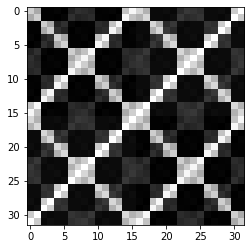

In [51]:
matrix, _ = utils.vector_to_matrix(low_rank_part, d, vector_modes)

plt.imshow(matrix, interpolation='nearest', cmap='gray')

In [53]:
print(np.max(matrix - np.full(matrix.shape, 255)))
#почти всегда 255

3.0210984476752856e-05


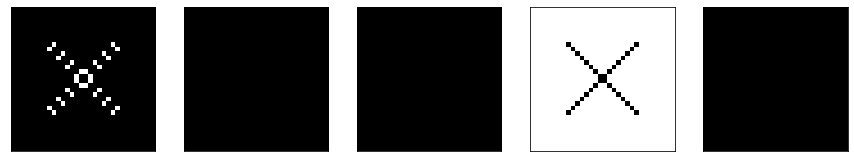

In [54]:
fig = plt.figure(figsize=(15, 3))
sparse_to_show = []
for s in preproc_2.sparse_parts:
    sparse_to_show.append(utils.vector_to_matrix(s.toarray().flatten(order='F'), d, vector_modes)[0])

for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1)
    ax.imshow(
        sparse_to_show[i],
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])

In [55]:
[s.data.size for s in sparse_parts]

[32, 0, 0, 64, 0]

In [56]:
ranks

[2, 3, 3, 1]